In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import decomposition
from sklearn import cluster
from skimage import transform as tf
import glob
from skimage.morphology  import disk, erosion
from skimage.restoration import inpaint
import cv2
import os 
from skimage.measure import label, regionprops

np.random.seed(1)

base_folder = '../input/' 
csv_filename = 'youtube_faces_with_keypoints_full.csv'
videoDF = pd.read_csv(os.path.join(base_folder, csv_filename))
npz_files_full_path = glob.glob(base_folder + 'youtube_faces_*/*/*.npz')
videoIDs = [x.split('/')[-1].split('.')[0] for x in npz_files_full_path]
full_paths = {}
for videoID, fullPath in zip(videoIDs, npz_files_full_path):
    full_paths[videoID] = fullPath

videoDF = videoDF.loc[videoDF.loc[:,'videoID'].isin(full_paths.keys()),:].reset_index(drop=True)

In [2]:
NUM_LANDMARKS = 68
NUM_DIMS = 2
def normlize_shapes(shapes_im_coords):
    (num_points, num_dims, _) = shapes_im_coords.shape
    mean_coords = shapes_im_coords.mean(axis=0)
    shapes_centered = np.zeros(shapes_im_coords.shape)
    shapes_centered = shapes_im_coords - np.tile(mean_coords,[num_points, 1, 1])
    scale_factors = np.sqrt((shapes_centered**2).sum(axis=1)).mean(axis=0)
    shapes_normlized = np.zeros(shapes_centered.shape)
    shapes_normlized = shapes_centered / np.tile(scale_factors, [num_points, num_dims, 1])

    return shapes_normlized, scale_factors, mean_coords

total_num_frames = videoDF['videoDuration'].sum()
landmarks2D_all = np.zeros((NUM_LANDMARKS, NUM_DIMS,int(total_num_frames)))
shape_ind_to_videoID_map = {}

end_ind = 0
for i, videoID in enumerate(videoDF['videoID']):
    video_file  = np.load(full_paths[videoID])
    landmarks2D = video_file['landmarks2D']

    start_ind = end_ind
    end_ind   = start_ind + landmarks2D.shape[2]
    landmarks2D_all[:,:,start_ind:end_ind] = landmarks2D
    for videoFrameInd, shapeInd in enumerate(range(start_ind,end_ind)):
        shape_ind_to_videoID_map[shapeInd] = (videoID, videoFrameInd)
landmarks2D_normlized, _, _  = normlize_shapes(landmarks2D_all)

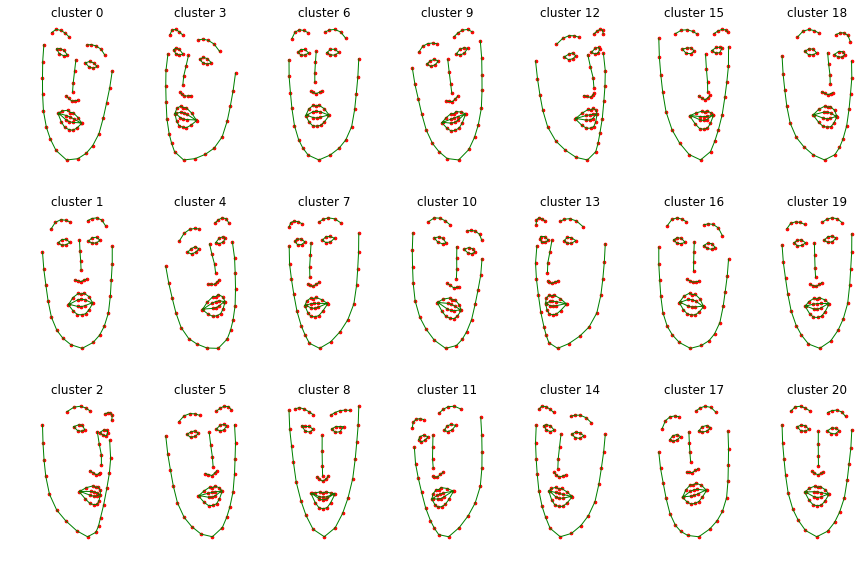

In [3]:
num_cols = 7
num_rows = 3
num_clusters = num_cols * num_rows
normalized_shapes_table = np.reshape(landmarks2D_normlized, [NUM_LANDMARKS * NUM_DIMS, landmarks2D_normlized.shape[2]]).T
ShapesKmeansModel  = cluster.KMeans(n_clusters=num_clusters, n_init=5, random_state=1).fit(normalized_shapes_table)
cluster_assignment = ShapesKmeansModel.predict(normalized_shapes_table)
ShapesPCAModel = decomposition.PCA(n_components=30).fit(normalized_shapes_table)
jaw_points           = range( 0,17)
rigth_eyebrow_points = range(17,22)
left_eyebrow_points  = range(22,27)
nose_ridge_points    = range(27,31)
nose_base_points     = range(31,36)
right_eye_points     = range(36,42)
left_eye_points      = range(42,48)
outer_mouth_points   = range(48,60)
inner_mouth_points   = range(60,68)
closing_right_eye   = [36,41]
closing_left_eye    = [42,47]
closing_outer_mouth = [48,59]
closing_inner_mouth = [60,67]

list_of_connected_points = [jaw_points, rigth_eyebrow_points, left_eyebrow_points, nose_ridge_points, nose_base_points,
                            right_eye_points, left_eye_points, outer_mouth_points, inner_mouth_points,
                            closing_right_eye, closing_left_eye, closing_outer_mouth, closing_inner_mouth]

fig, ax = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(12,8))
for i in range(num_clusters):
    curr_landmarks2D = np.reshape(ShapesKmeansModel.cluster_centers_[i,:], [NUM_LANDMARKS, NUM_DIMS])
    ax[i%num_rows,i//num_rows].scatter(curr_landmarks2D[:,0], -curr_landmarks2D[:,1], c='r',s=7.0)
    for conPts in list_of_connected_points:
        xPts = curr_landmarks2D[conPts,0]
        yPts = curr_landmarks2D[conPts,1]
        ax[i % num_rows,i // num_rows].plot(xPts,-yPts,color='g',linewidth=1.0)         
    ax[i % num_rows, i // num_rows].set_title('cluster %d' %(i))
    ax[i % num_rows, i // num_rows].set_axis_off()
fig.tight_layout()


In [4]:
def warp_im_picewise_affine(src_im, src_coords, dst_coords, target_im_size=None):
    requested_transfromation = tf.estimate_transform('piecewise-affine',src_coords,dst_coords)
    warped_im = tf.warp(src_im,requested_transfromation.inverse,output_shape=target_im_size)
    return warped_im

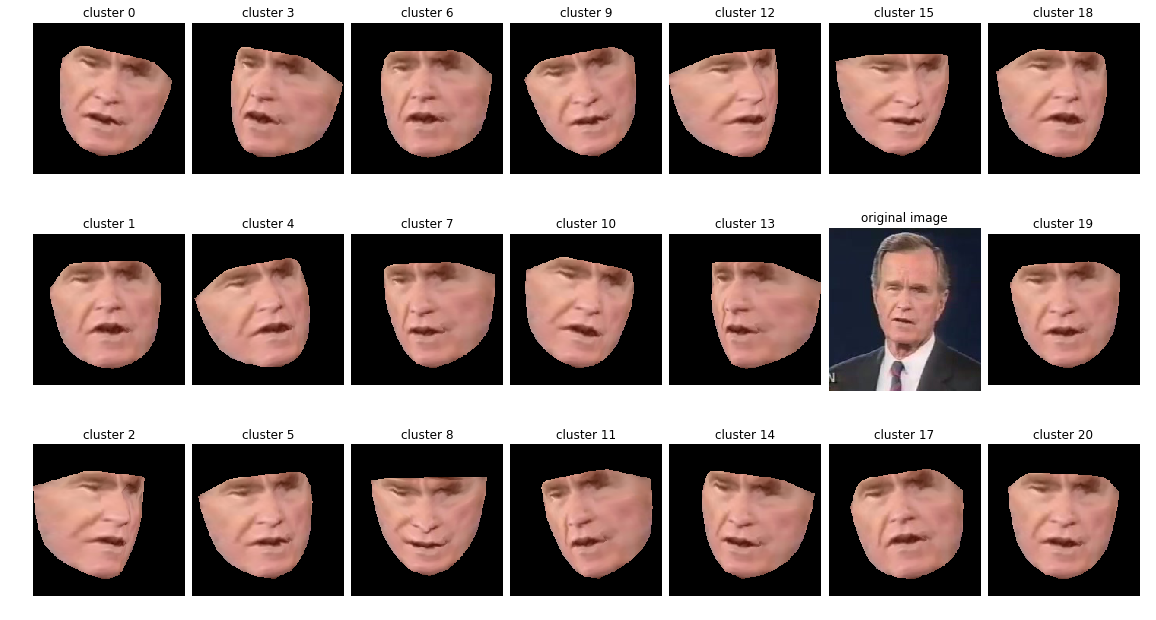

In [6]:
np.random.seed(1)
large_faces_videoIDs = videoDF.loc[videoDF['averageFaceSize'] > 80, 'videoID'].tolist()
shape_ind_large_face_only = []
for key, value in shape_ind_to_videoID_map.items():
    if value[0] in large_faces_videoIDs:
        shape_ind_large_face_only.append(key)
shape_ind_large_face_only = np.array(shape_ind_large_face_only)
        
overlay_landmarks = False
frontal_shape_cluster_ind = 16
frontal_inds = np.nonzero(cluster_assignment == frontal_shape_cluster_ind)[0]
frontal_inds = np.array(list(set(frontal_inds).intersection(set(shape_ind_large_face_only))))

some_frontal_image_ind = np.random.choice(frontal_inds,size=1)[0]

selected_videoID = shape_ind_to_videoID_map[some_frontal_image_ind][0]
selected_video_frame = shape_ind_to_videoID_map[some_frontal_image_ind][1]

video_file = np.load(full_paths[selected_videoID])
selected_frontal_image = video_file['colorImages'][:,:,:,selected_video_frame]
selected_frontal_shape = video_file['landmarks2D'][:,:,selected_video_frame]

plt.close('all')
fig, ax = plt.subplots(nrows=num_rows,ncols=num_cols,figsize=(16,9))
for i in range(num_clusters):
    curr_landmarks2D_norm = np.reshape(ShapesKmeansModel.cluster_centers_[i,:], [NUM_LANDMARKS,NUM_DIMS])
    curr_landmarks2D_norm_rec = ShapesPCAModel.transform(curr_landmarks2D_norm.reshape([1,NUM_LANDMARKS*NUM_DIMS]))
    curr_landmarks2D_norm_rec = ShapesPCAModel.inverse_transform(curr_landmarks2D_norm_rec)
    curr_landmarks2D_norm_rec = curr_landmarks2D_norm_rec.reshape([NUM_LANDMARKS,NUM_DIMS])
    
    curr_landmarks2D =  50 * curr_landmarks2D_norm_rec
    curr_landmarks2D += 100
    
    if i == frontal_shape_cluster_ind:
        ax[i % num_rows, i // num_rows].imshow(selected_frontal_image)
        ax[i % num_rows, i // num_rows].set_title('original image')
    else:
        warped_im = warp_im_picewise_affine(selected_frontal_image, selected_frontal_shape, curr_landmarks2D, target_im_size=[200,200])
        ax[i % num_rows, i // num_rows].imshow(warped_im)
        ax[i % num_rows, i // num_rows].set_title('cluster %d' %(i))
        if overlay_landmarks:
            ax[i % num_rows, i // num_rows].scatter(curr_landmarks2D[:,0], curr_landmarks2D[:,1], c='r', s=1.3)
            for conPts in list_of_connected_points:
                xPts = curr_landmarks2D[conPts,0]
                yPts = curr_landmarks2D[conPts,1]
                ax[i % num_rows, i // num_rows].plot(xPts,yPts,color='g',linewidth=0.6) 
    ax[i % num_rows,i // num_rows].set_axis_off()
fig.tight_layout()
fig.subplots_adjust(left=0.02, bottom=0.02, right=0.98, top=0.98, wspace=0.05, hspace=0.05)


In [7]:
def embed_image_in_another_image(image_to_embed, target_image, inpaint_boarders=True):
    assert(image_to_embed.shape[0] == target_image.shape[0])
    assert(image_to_embed.shape[1] == target_image.shape[1])
    embedding_mask = np.any(image_to_embed, axis=2)
    overlayed_im = target_image.copy()
    if image_to_embed.dtype in [np.float16, np.float32, np.float64]:
        overlayed_im[embedding_mask] = 255 * image_to_embed[embedding_mask]
    else:
        overlayed_im[embedding_mask] = image_to_embed[embedding_mask]
    if inpaint_boarders:
        embedding_mask_eroded = erosion(embedding_mask, disk(3.5))    
        embedding_mask_boundry = np.bitwise_and(embedding_mask, 
                                                np.logical_not(embedding_mask_eroded))
        overlayed_im = inpaint.inpaint_biharmonic(overlayed_im, embedding_mask_boundry, 
                                                  multichannel=True)

    return overlayed_im

In [8]:
def interpret_using_shape_model(ShapesPCAModel, shape):
    shape_norm, scale, trans = normlize_shapes(shape[:,:,np.newaxis])
    shape_norm_rec = ShapesPCAModel.inverse_transform(ShapesPCAModel.transform(shape_norm.reshape([1,NUM_LANDMARKS*NUM_DIMS])))
    shape_norm_rec = shape_norm_rec.reshape([NUM_LANDMARKS,NUM_DIMS])
    shape_rec = scale[0]*shape_norm_rec
    shape_rec[:,0] += trans[0,0]
    shape_rec[:,1] += trans[1,0]

    return shape_rec

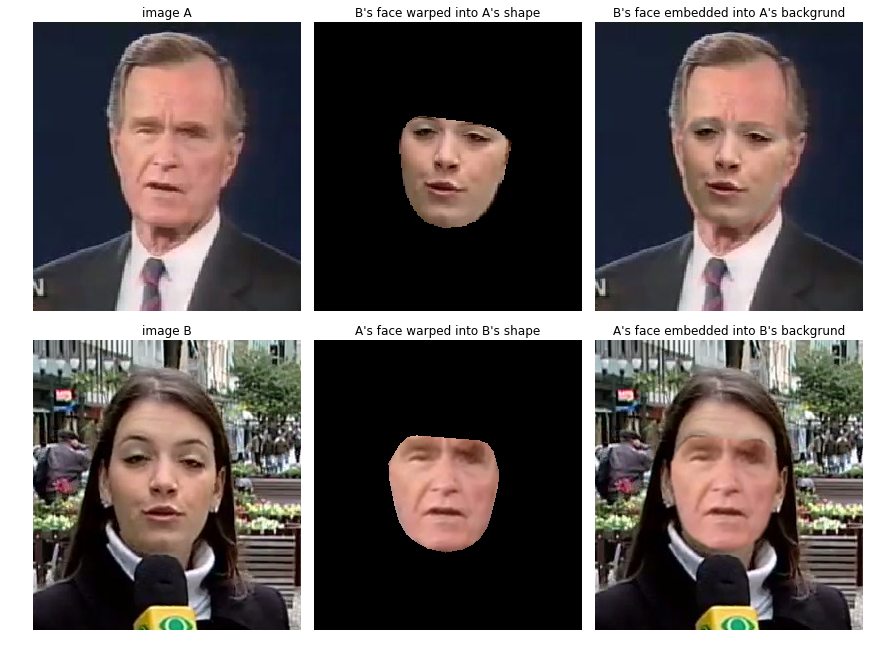

In [9]:
np.random.seed(1)
almost_frontal_shape_cluster_inds = [0,1,5,6,8,9,10,11,14,15,16,17,18,19,20]
almost_frontal_inds = np.nonzero([x in almost_frontal_shape_cluster_inds for x in cluster_assignment])[0]
almost_frontal_inds = np.array(list(set(almost_frontal_inds).intersection(set(shape_ind_large_face_only))))

some_frontal_image_inds = np.random.choice(frontal_inds,size=2)
selected_videoID_A     = shape_ind_to_videoID_map[some_frontal_image_inds[0]][0]
selected_video_frame_A = shape_ind_to_videoID_map[some_frontal_image_inds[0]][1]
selected_videoID_B     = shape_ind_to_videoID_map[some_frontal_image_inds[1]][0]
selected_video_frame_B = shape_ind_to_videoID_map[some_frontal_image_inds[1]][1]

video_file_A = np.load(full_paths[selected_videoID_A])
image_A = video_file_A['colorImages'][:,:,:,selected_video_frame_A]
shape_A = video_file_A['landmarks2D'][:,:,selected_video_frame_A]
shape_A = interpret_using_shape_model(ShapesPCAModel, shape_A)
image_A_size = image_A.shape[:2]

video_file_B = np.load(full_paths[selected_videoID_B])
image_B = video_file_B['colorImages'][:,:,:,selected_video_frame_B]
shape_B = video_file_B['landmarks2D'][:,:,selected_video_frame_B]
shape_B = interpret_using_shape_model(ShapesPCAModel, shape_B)
image_B_size = image_B.shape[:2]

A_warped_into_B = warp_im_picewise_affine(image_A, shape_A, shape_B, target_im_size=image_B_size)
B_warped_into_A = warp_im_picewise_affine(image_B, shape_B, shape_A, target_im_size=image_A_size)

A_embedded_into_B = embed_image_in_another_image(A_warped_into_B, image_B)
B_embedded_into_A = embed_image_in_another_image(B_warped_into_A, image_A)

plt.figure(figsize=(12,9))
plt.subplots_adjust(left=0.02, bottom=0.02, right=0.98, top=0.98, wspace=0.05, hspace=0.05)
plt.subplot(2,3,1); plt.imshow(image_A); plt.title('image A'); plt.axis('off');
plt.subplot(2,3,2); plt.imshow(B_warped_into_A); plt.title("B's face warped into A's shape"); plt.axis('off');
plt.subplot(2,3,3); plt.imshow(B_embedded_into_A); plt.title("B's face embedded into A's backgrund"); plt.axis('off');
plt.subplot(2,3,4); plt.imshow(image_B); plt.title('image B'); plt.axis('off');
plt.subplot(2,3,5); plt.imshow(A_warped_into_B); plt.title("A's face warped into B's shape"); plt.axis('off');
plt.subplot(2,3,6); plt.imshow(A_embedded_into_B); plt.title("A's face embedded into B's backgrund"); plt.axis('off');


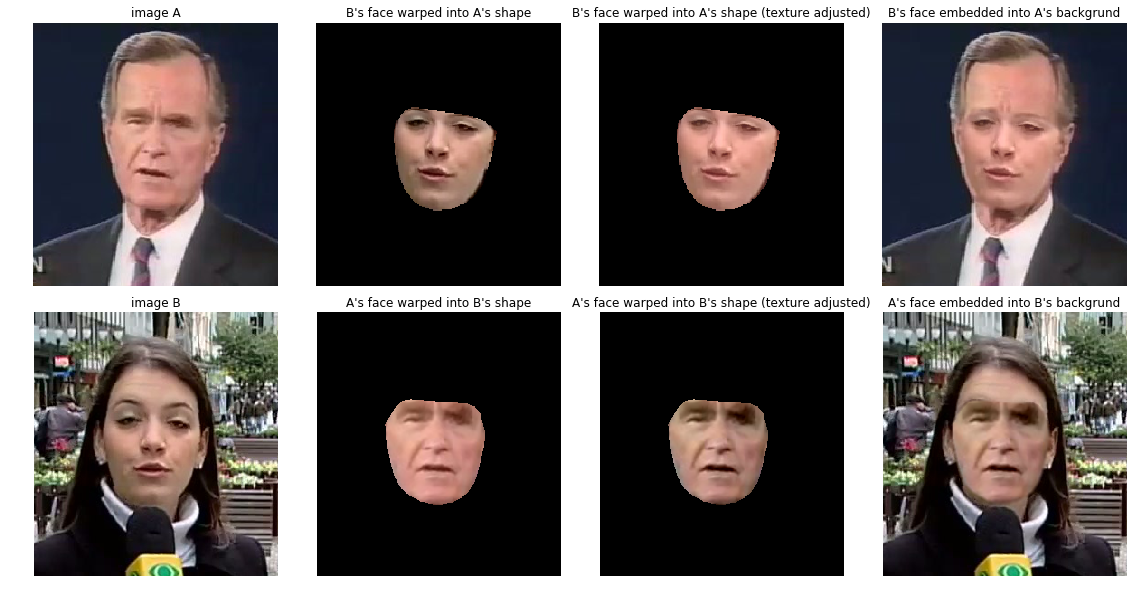

In [10]:
np.random.seed(1)
almost_frontal_shape_cluster_inds = [0,1,5,6,8,9,10,11,14,15,16,17,18,19,20]
almost_frontal_inds = np.nonzero([x in almost_frontal_shape_cluster_inds for x in cluster_assignment])[0]
almost_frontal_inds = np.array(list(set(almost_frontal_inds).intersection(set(shape_ind_large_face_only))))

some_frontal_image_inds = np.random.choice(frontal_inds,size=2)
selected_videoID_A     = shape_ind_to_videoID_map[some_frontal_image_inds[0]][0]
selected_video_frame_A = shape_ind_to_videoID_map[some_frontal_image_inds[0]][1]
selected_videoID_B     = shape_ind_to_videoID_map[some_frontal_image_inds[1]][0]
selected_video_frame_B = shape_ind_to_videoID_map[some_frontal_image_inds[1]][1]

video_file_A = np.load(full_paths[selected_videoID_A])
image_A = video_file_A['colorImages'][:,:,:,selected_video_frame_A]
shape_A = video_file_A['landmarks2D'][:,:,selected_video_frame_A]
shape_A = interpret_using_shape_model(ShapesPCAModel, shape_A)
image_A_size = image_A.shape[:2]

video_file_B = np.load(full_paths[selected_videoID_B])
image_B = video_file_B['colorImages'][:,:,:,selected_video_frame_B]
shape_B = video_file_B['landmarks2D'][:,:,selected_video_frame_B]
shape_B = interpret_using_shape_model(ShapesPCAModel, shape_B)
image_B_size = image_B.shape[:2]

A_warped_into_B = warp_im_picewise_affine(image_A, shape_A, shape_B, target_im_size=image_B_size)
B_warped_into_A = warp_im_picewise_affine(image_B, shape_B, shape_A, target_im_size=image_A_size)

A_warped_into_B_mask = np.any(A_warped_into_B, axis=2)
B_warped_into_A_mask = np.any(B_warped_into_A, axis=2)

A_texture_pixels = A_warped_into_B[A_warped_into_B_mask]
A_texture_mean   = A_texture_pixels.mean(axis=0)
A_texture_std    = np.sqrt(np.sum(A_texture_pixels**2,axis=1)).std()
B_texture_pixels = B_warped_into_A[B_warped_into_A_mask]
B_texture_mean   = B_texture_pixels.mean(axis=0)
B_texture_std    = np.sqrt(np.sum(B_texture_pixels**2,axis=1)).std()

A_texture_pixels_norm = A_texture_pixels - np.tile(A_texture_mean[np.newaxis,:],[A_texture_pixels.shape[0],1])
A_texture_pixels_norm /= A_texture_std
B_texture_pixels_norm = B_texture_pixels - np.tile(B_texture_mean[np.newaxis,:],[B_texture_pixels.shape[0],1])
B_texture_pixels_norm /= B_texture_std

B_texture_pixels_adjusted = B_texture_pixels_norm * A_texture_std
B_texture_pixels_adjusted = B_texture_pixels_adjusted + np.tile(A_texture_mean[np.newaxis,:],[B_texture_pixels.shape[0],1])
A_texture_pixels_adjusted = A_texture_pixels_norm * B_texture_std
A_texture_pixels_adjusted = A_texture_pixels_adjusted + np.tile(B_texture_mean[np.newaxis,:],[A_texture_pixels.shape[0],1])

A_warped_into_B_adjusted = A_warped_into_B.copy()
A_warped_into_B_adjusted[A_warped_into_B_mask] = A_texture_pixels_adjusted
A_warped_into_B_adjusted[A_warped_into_B_adjusted < 0] = 0
A_warped_into_B_adjusted[A_warped_into_B_adjusted > 1] = 1

B_warped_into_A_adjusted = B_warped_into_A.copy()
B_warped_into_A_adjusted[B_warped_into_A_mask] = B_texture_pixels_adjusted
B_warped_into_A_adjusted[B_warped_into_A_adjusted < 0] = 0
B_warped_into_A_adjusted[B_warped_into_A_adjusted > 1] = 1

A_embedded_into_B = embed_image_in_another_image(A_warped_into_B_adjusted, image_B)
B_embedded_into_A = embed_image_in_another_image(B_warped_into_A_adjusted, image_A)

plt.figure(figsize=(16,8))
plt.subplots_adjust(left=0.02, bottom=0.02, right=0.98, top=0.98, wspace=0.1, hspace=0.1)
plt.subplot(2,4,1); plt.imshow(image_A); plt.title('image A'); plt.axis('off');
plt.subplot(2,4,2); plt.imshow(B_warped_into_A); plt.title("B's face warped into A's shape"); plt.axis('off');
plt.subplot(2,4,3); plt.imshow(B_warped_into_A_adjusted); plt.title("B's face warped into A's shape (texture adjusted)"); plt.axis('off');
plt.subplot(2,4,4); plt.imshow(B_embedded_into_A); plt.title("B's face embedded into A's backgrund"); plt.axis('off');
plt.subplot(2,4,5); plt.imshow(image_B); plt.title('image B'); plt.axis('off');
plt.subplot(2,4,6); plt.imshow(A_warped_into_B); plt.title("A's face warped into B's shape"); plt.axis('off');
plt.subplot(2,4,7); plt.imshow(A_warped_into_B_adjusted); plt.title("A's face warped into B's shape (texture adjusted)"); plt.axis('off');
plt.subplot(2,4,8); plt.imshow(A_embedded_into_B); plt.title("A's face embedded into B's backgrund"); plt.axis('off');

In [11]:
def apply_aligned_poission_blending(background_image, foreground_image, foreground_mask):
    kernel_morph    = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    foreground_mask = cv2.erode(foreground_mask.astype(np.uint8), kernel_morph, iterations=1) 

    foreground_mask[0,:]  = False
    foreground_mask[:,0]  = False
    foreground_mask[-1,:] = False
    foreground_mask[:,-1] = False

    mask_label_image = label(foreground_mask)
    regions = regionprops(mask_label_image)
    min_row, min_col, max_row, max_col = regions[0].bbox

    if (min_row + max_row) % 2 == 1:
        min_row -= 1
    if (min_col + max_col) % 2 == 1:
        min_col -= 1

    center = (int((min_col + max_col) / 2), int((min_row + max_row) / 2))
    new_face_im_cropped   = foreground_image[min_row:max_row,min_col:max_col]
    new_face_mask_cropped = (255.0*foreground_mask[min_row:max_row,min_col:max_col]).astype(np.uint8)

    blended_image = cv2.seamlessClone(new_face_im_cropped, background_image, new_face_mask_cropped.copy(), center, cv2.NORMAL_CLONE)

    return blended_image

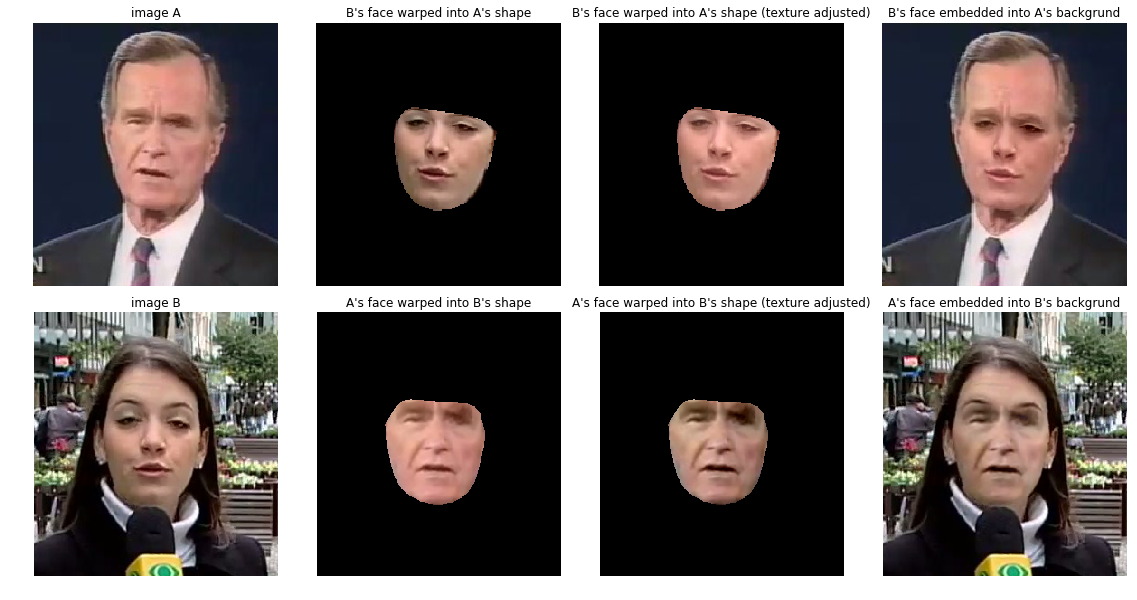

In [12]:
np.random.seed(1)

almost_frontal_shape_cluster_inds = [0,1,5,6,8,9,10,11,14,15,16,17,18,19,20]
almost_frontal_inds = np.nonzero([x in almost_frontal_shape_cluster_inds for x in cluster_assignment])[0]
almost_frontal_inds = np.array(list(set(almost_frontal_inds).intersection(set(shape_ind_large_face_only))))

some_frontal_image_inds = np.random.choice(frontal_inds,size=2)
selected_videoID_A     = shape_ind_to_videoID_map[some_frontal_image_inds[0]][0]
selected_video_frame_A = shape_ind_to_videoID_map[some_frontal_image_inds[0]][1]
selected_videoID_B     = shape_ind_to_videoID_map[some_frontal_image_inds[1]][0]
selected_video_frame_B = shape_ind_to_videoID_map[some_frontal_image_inds[1]][1]

video_file_A = np.load(full_paths[selected_videoID_A])
image_A = video_file_A['colorImages'][:,:,:,selected_video_frame_A]
shape_A = video_file_A['landmarks2D'][:,:,selected_video_frame_A]
shape_A = interpret_using_shape_model(ShapesPCAModel, shape_A)
image_A_size = image_A.shape[:2]

video_file_B = np.load(full_paths[selected_videoID_B])
image_B = video_file_B['colorImages'][:,:,:,selected_video_frame_B]
shape_B = video_file_B['landmarks2D'][:,:,selected_video_frame_B]
shape_B = interpret_using_shape_model(ShapesPCAModel, shape_B)
image_B_size = image_B.shape[:2]

A_warped_into_B = warp_im_picewise_affine(image_A, shape_A, shape_B, target_im_size=image_B_size)
B_warped_into_A = warp_im_picewise_affine(image_B, shape_B, shape_A, target_im_size=image_A_size)

A_warped_into_B_mask = np.any(A_warped_into_B, axis=2)
B_warped_into_A_mask = np.any(B_warped_into_A, axis=2)

A_texture_pixels = A_warped_into_B[A_warped_into_B_mask]
A_texture_mean   = A_texture_pixels.mean(axis=0)
A_texture_std    = np.sqrt(np.sum(A_texture_pixels**2,axis=1)).std()
B_texture_pixels = B_warped_into_A[B_warped_into_A_mask]
B_texture_mean   = B_texture_pixels.mean(axis=0)
B_texture_std    = np.sqrt(np.sum(B_texture_pixels**2,axis=1)).std()

A_texture_pixels_norm = A_texture_pixels - np.tile(A_texture_mean[np.newaxis,:], [A_texture_pixels.shape[0], 1])
A_texture_pixels_norm /= A_texture_std
B_texture_pixels_norm = B_texture_pixels - np.tile(B_texture_mean[np.newaxis,:], [B_texture_pixels.shape[0], 1])
B_texture_pixels_norm /= B_texture_std

B_texture_pixels_adjusted = B_texture_pixels_norm * A_texture_std
B_texture_pixels_adjusted = B_texture_pixels_adjusted + np.tile(A_texture_mean[np.newaxis,:], [B_texture_pixels.shape[0], 1])
A_texture_pixels_adjusted = A_texture_pixels_norm * B_texture_std
A_texture_pixels_adjusted = A_texture_pixels_adjusted + np.tile(B_texture_mean[np.newaxis,:], [A_texture_pixels.shape[0], 1])

A_warped_into_B_adjusted = A_warped_into_B.copy()
A_warped_into_B_adjusted[A_warped_into_B_mask] = A_texture_pixels_adjusted
A_warped_into_B_adjusted[A_warped_into_B_adjusted < 0] = 0
A_warped_into_B_adjusted[A_warped_into_B_adjusted > 1] = 1

B_warped_into_A_adjusted = B_warped_into_A.copy()
B_warped_into_A_adjusted[B_warped_into_A_mask] = B_texture_pixels_adjusted
B_warped_into_A_adjusted[B_warped_into_A_adjusted < 0] = 0
B_warped_into_A_adjusted[B_warped_into_A_adjusted > 1] = 1

B_warped_into_A_adjusted = (255 * B_warped_into_A_adjusted).astype(np.uint8)
A_warped_into_B_adjusted = (255 * A_warped_into_B_adjusted).astype(np.uint8)

A_warped_into_B_adjusted_mask = np.any(A_warped_into_B_adjusted, axis=2)
B_warped_into_A_adjusted_mask = np.any(B_warped_into_A_adjusted, axis=2)

A_embedded_into_B = apply_aligned_poission_blending(image_B, A_warped_into_B_adjusted, A_warped_into_B_adjusted_mask)
B_embedded_into_A = apply_aligned_poission_blending(image_A, B_warped_into_A_adjusted, B_warped_into_A_adjusted_mask)

plt.figure(figsize=(16,8))
plt.subplots_adjust(left=0.02, bottom=0.02, right=0.98, top=0.98, wspace=0.1, hspace=0.1)
plt.subplot(2,4,1); plt.imshow(image_A); plt.title('image A'); plt.axis('off');
plt.subplot(2,4,2); plt.imshow(B_warped_into_A); plt.title("B's face warped into A's shape"); plt.axis('off');
plt.subplot(2,4,3); plt.imshow(B_warped_into_A_adjusted); plt.title("B's face warped into A's shape (texture adjusted)"); plt.axis('off');
plt.subplot(2,4,4); plt.imshow(B_embedded_into_A); plt.title("B's face embedded into A's backgrund"); plt.axis('off');
plt.subplot(2,4,5); plt.imshow(image_B); plt.title('image B'); plt.axis('off');
plt.subplot(2,4,6); plt.imshow(A_warped_into_B); plt.title("A's face warped into B's shape"); plt.axis('off');
plt.subplot(2,4,7); plt.imshow(A_warped_into_B_adjusted); plt.title("A's face warped into B's shape (texture adjusted)"); plt.axis('off');
plt.subplot(2,4,8); plt.imshow(A_embedded_into_B); plt.title("A's face embedded into B's backgrund"); plt.axis('off');

In [13]:
def face_swap(image_A, shape_A, image_B, shape_B):
    
    image_A_size = image_A.shape[:2]
    image_B_size = image_B.shape[:2]

    A_warped_into_B = warp_im_picewise_affine(image_A, shape_A, shape_B, target_im_size=image_B_size)
    B_warped_into_A = warp_im_picewise_affine(image_B, shape_B, shape_A, target_im_size=image_A_size)

    A_warped_into_B_mask = np.any(A_warped_into_B, axis=2)
    B_warped_into_A_mask = np.any(B_warped_into_A, axis=2)

    A_texture_pixels = A_warped_into_B[A_warped_into_B_mask]
    A_texture_mean   = A_texture_pixels.mean(axis=0)
    A_texture_std    = np.sqrt(np.sum(A_texture_pixels**2, axis=1)).std()
    B_texture_pixels = B_warped_into_A[B_warped_into_A_mask]
    B_texture_mean   = B_texture_pixels.mean(axis=0)
    B_texture_std    = np.sqrt(np.sum(B_texture_pixels**2, axis=1)).std()

    A_texture_pixels_norm = A_texture_pixels - np.tile(A_texture_mean[np.newaxis,:], [A_texture_pixels.shape[0], 1])
    A_texture_pixels_norm /= A_texture_std
    B_texture_pixels_norm = B_texture_pixels - np.tile(B_texture_mean[np.newaxis,:], [B_texture_pixels.shape[0], 1])
    B_texture_pixels_norm /= B_texture_std

    B_texture_pixels_adjusted = B_texture_pixels_norm * A_texture_std
    B_texture_pixels_adjusted = B_texture_pixels_adjusted + np.tile(A_texture_mean[np.newaxis,:], [B_texture_pixels.shape[0], 1])
    A_texture_pixels_adjusted = A_texture_pixels_norm * B_texture_std
    A_texture_pixels_adjusted = A_texture_pixels_adjusted + np.tile(B_texture_mean[np.newaxis,:], [A_texture_pixels.shape[0], 1])

    A_warped_into_B_adjusted = A_warped_into_B.copy()
    A_warped_into_B_adjusted[A_warped_into_B_mask] = A_texture_pixels_adjusted
    A_warped_into_B_adjusted[A_warped_into_B_adjusted < 0] = 0
    A_warped_into_B_adjusted[A_warped_into_B_adjusted > 1] = 1
    B_warped_into_A_adjusted = B_warped_into_A.copy()
    B_warped_into_A_adjusted[B_warped_into_A_mask] = B_texture_pixels_adjusted
    B_warped_into_A_adjusted[B_warped_into_A_adjusted < 0] = 0
    B_warped_into_A_adjusted[B_warped_into_A_adjusted > 1] = 1

    B_warped_into_A_adjusted = (255 * B_warped_into_A_adjusted).astype(np.uint8)
    A_warped_into_B_adjusted = (255 * A_warped_into_B_adjusted).astype(np.uint8)

    A_warped_into_B_adjusted_mask = np.any(A_warped_into_B_adjusted, axis=2)
    B_warped_into_A_adjusted_mask = np.any(B_warped_into_A_adjusted, axis=2)

    A_embedded_into_B = apply_aligned_poission_blending(image_B, A_warped_into_B_adjusted, A_warped_into_B_adjusted_mask)
    B_embedded_into_A = apply_aligned_poission_blending(image_A, B_warped_into_A_adjusted, B_warped_into_A_adjusted_mask)

    return A_embedded_into_B, B_embedded_into_A

In [15]:
"""
np.random.seed(7)

almost_frontal_shape_cluster_inds = [0,1,5,6,8,9,10,11,14,15,16,17,18,19,20]
almost_frontal_inds = np.nonzero([x in almost_frontal_shape_cluster_inds for x in cluster_assignment])[0]
almost_frontal_inds = np.array(list(set(almost_frontal_inds).intersection(set(shape_ind_large_face_only))))

num_pairs = 4

plt.figure(figsize=(22,16))
plt.subplots_adjust(left=0.02, bottom=0.02, right=0.98, top=0.98, wspace=0.05, hspace=0.2)
for k in range(num_pairs):
    some_frontal_image_inds = np.random.choice(frontal_inds,size=2)
    selected_videoID_A     = shape_ind_to_videoID_map[some_frontal_image_inds[0]][0]
    selected_video_frame_A = shape_ind_to_videoID_map[some_frontal_image_inds[0]][1]
    selected_videoID_B     = shape_ind_to_videoID_map[some_frontal_image_inds[1]][0]
    selected_video_frame_B = shape_ind_to_videoID_map[some_frontal_image_inds[1]][1]

    video_file_A = np.load(full_paths[selected_videoID_A])
    image_A = video_file_A['colorImages'][:,:,:,selected_video_frame_A]
    shape_A = video_file_A['landmarks2D'][:,:,selected_video_frame_A]
    shape_A = interpret_using_shape_model(ShapesPCAModel, shape_A)

    video_file_B = np.load(full_paths[selected_videoID_B])
    image_B = video_file_B['colorImages'][:,:,:,selected_video_frame_B]
    shape_B = video_file_B['landmarks2D'][:,:,selected_video_frame_B]
    shape_B = interpret_using_shape_model(ShapesPCAModel, shape_B)

    A_embedded_into_B, B_embedded_into_A = face_swap(image_A, shape_A, image_B, shape_B)
    
    plt.subplot(4, num_pairs, k + 1 + 0*num_pairs); plt.imshow(B_embedded_into_A); plt.title("B face, A backgrund"); plt.axis('off');
    plt.subplot(4, num_pairs, k + 1 + 1*num_pairs); plt.imshow(A_embedded_into_B); plt.title("A face, B backgrund"); plt.axis('off');
    plt.subplot(4, num_pairs, k + 1 + 2*num_pairs); plt.imshow(image_A); plt.title('image A'); plt.axis('off');
    plt.subplot(4, num_pairs, k + 1 + 3*num_pairs); plt.imshow(image_B); plt.title('image B'); plt.axis('off');
"""

'\nnp.random.seed(7)\n\nalmost_frontal_shape_cluster_inds = [0,1,5,6,8,9,10,11,14,15,16,17,18,19,20]\nalmost_frontal_inds = np.nonzero([x in almost_frontal_shape_cluster_inds for x in cluster_assignment])[0]\nalmost_frontal_inds = np.array(list(set(almost_frontal_inds).intersection(set(shape_ind_large_face_only))))\n\nnum_pairs = 4\n\nplt.figure(figsize=(22,16))\nplt.subplots_adjust(left=0.02, bottom=0.02, right=0.98, top=0.98, wspace=0.05, hspace=0.2)\nfor k in range(num_pairs):\n    some_frontal_image_inds = np.random.choice(frontal_inds,size=2)\n    selected_videoID_A     = shape_ind_to_videoID_map[some_frontal_image_inds[0]][0]\n    selected_video_frame_A = shape_ind_to_videoID_map[some_frontal_image_inds[0]][1]\n    selected_videoID_B     = shape_ind_to_videoID_map[some_frontal_image_inds[1]][0]\n    selected_video_frame_B = shape_ind_to_videoID_map[some_frontal_image_inds[1]][1]\n\n    video_file_A = np.load(full_paths[selected_videoID_A])\n    image_A = video_file_A[\'colorImage